In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation
from dariah_topics import doclist
from dariah_topics import meta

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_ = doclist.PathDocList(path_txt)
doclist_txt = doclist_.full_paths(as_str=True)
doclist_txt

['corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt',
 'corpus_txt/Howard_SchadowsinZamboula.txt',
 'corpus_txt/Howard_ShadowsintheMoonlight.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Kipling_TheEndofthePassage.txt',
 'corpus_txt/Kipling_TheJungleBook.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt',
 'corpus_txt/Lovecraft_AttheMountainofMadness.txt',
 'corpus_txt/Lovecraft_TheShunnedHouse.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt',
 'corpus_txt/Poe_ThePurloinedLetter.txt']

####  Liste mit Dokumentenlabels erzeugen

In [3]:
doc_labels = doclist_.labels()
doc_labels

['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth',
 'Howard_SchadowsinZamboula',
 'Howard_ShadowsintheMoonlight',
 'Howard_TheDevilinIron',
 'Kipling_TheEndofthePassage',
 'Kipling_TheJungleBook',
 'Kipling_ThyServantaDog',
 'Lovecraft_AttheMountainofMadness',
 'Lovecraft_TheShunnedHouse',
 'Poe_EurekaAProsePoem',
 'Poe_TheCaskofAmontillado',
 'Poe_TheMasqueoftheRedDeath',
 'Poe_ThePurloinedLetter']

#### Metadaten (alternativ zu `PathDocList`)

In [4]:
md = meta.fn2metadata('corpus_txt/*.txt')
md

,author,basename,filename,title
0,Doyle,Doyle_AScandalinBohemia,corpus_txt/Doyle_AScandalinBohemia.txt,AScandalinBohemia
1,Doyle,Doyle_AStudyinScarlet,corpus_txt/Doyle_AStudyinScarlet.txt,AStudyinScarlet
2,Doyle,Doyle_TheHoundoftheBaskervilles,corpus_txt/Doyle_TheHoundoftheBaskervilles.txt,TheHoundoftheBaskervilles
3,Doyle,Doyle_TheSignoftheFour,corpus_txt/Doyle_TheSignoftheFour.txt,TheSignoftheFour
4,Howard,Howard_GodsoftheNorth,corpus_txt/Howard_GodsoftheNorth.txt,GodsoftheNorth
5,Howard,Howard_SchadowsinZamboula,corpus_txt/Howard_SchadowsinZamboula.txt,SchadowsinZamboula
6,Howard,Howard_ShadowsintheMoonlight,corpus_txt/Howard_ShadowsintheMoonlight.txt,ShadowsintheMoonlight
7,Howard,Howard_TheDevilinIron,corpus_txt/Howard_TheDevilinIron.txt,TheDevilinIron
8,Kipling,Kipling_TheEndofthePassage,corpus_txt/Kipling_TheEndofthePassage.txt,TheEndofthePassage
9,Kipling,Kipling_TheJungleBook,corpus_txt/Kipling_TheJungleBook.txt,TheJungleBook


#### Corpus laden

In [5]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [6]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

INFO preprocessing: Accessing TXT documents ...


#### Create Dictionaries

In [7]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [8]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [9]:
sparse_bow[:5]

0
doc_id token_id      
1      1202       270
       6804      2750
       4305        49
       822       1753
       19419       21

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [10]:
pre.save_sparse_bow(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [11]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

INFO summa.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English


In [12]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [13]:
corpus = MmCorpus('gensim_txt.mm')

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [14]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [15]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "en.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [16]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

INFO preprocessing: Finding hapax legomena ...
INFO preprocessing: Finding stopwords ...
INFO preprocessing: Removing features ...


In [17]:
len(features_to_be_removed)

75

In [18]:
pre.save_sparse_bow(sparse_bow_short, "gensim_txt")

In [19]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 192053 non-zero entries


#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [20]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [21]:
len(doc2bow_list)

17

In [22]:
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

INFO gensim.models.ldamodel: using symmetric alpha at 0.05
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 20 topics, 10 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 20x with a convergence threshold of 0.001000
INFO gensim.models.ldamodel: -14.379 per-word bound, 21304.5 perplexity estimate based on a held-out corpus of 17 documents with 192053 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #15 (0.050): 0.003*"ex-prize" + 0.003*"cameras" + 0.003*"arduous" + 0.003*"chaos" + 0.003*"nonchalance" + 0.003*"locally" + 0.003*"slow-footed" + 0.003*"rajah" + 0.003*"im-which" + 0.003*"earthward"
INFO gensim.models.ldamodel: topic #16 (0.050): 0.003*"ex-prize" + 0.003*"locally" + 0.003*"diagnosis

INFO gensim.models.ldamodel: topic #15 (0.050): 0.007*"nonchalance" + 0.005*"cameras" + 0.004*"faintly" + 0.004*"gallop" + 0.004*"ex-prize" + 0.003*"up-and" + 0.003*"uncomfy" + 0.003*"locally" + 0.003*"sub-lieutenant" + 0.003*"bags"
INFO gensim.models.ldamodel: topic #19 (0.050): 0.006*"obliterated" + 0.005*"well-ascertained" + 0.004*"arduous" + 0.004*"im-which" + 0.004*"defined" + 0.004*"crest-fallen" + 0.004*"footmarks" + 0.004*"individualized" + 0.004*"negative" + 0.003*"revision"
INFO gensim.models.ldamodel: topic #4 (0.050): 0.004*"obliterated" + 0.004*"typewriting" + 0.004*"offence-at" + 0.003*"indulging" + 0.003*"cameras" + 0.003*"earthward" + 0.003*"collapsible" + 0.003*"locally" + 0.003*"bracelets" + 0.003*"slow-footed"
INFO gensim.models.ldamodel: topic #12 (0.050): 0.001*"diagnosis" + 0.001*"cameras" + 0.001*"locally" + 0.001*"chaos" + 0.001*"earthward" + 0.001*"well-ascertained" + 0.001*"typewriting" + 0.001*"nonchalance" + 0.001*"slow-footed" + 0.001*"footmarks"
INFO gensi

In [23]:
model.get_document_topics(doc2bow_list[1])

[(0, 0.21092145449352817),
 (2, 0.088421008090027883),
 (3, 0.04709042797737098),
 (4, 0.12311292619277209),
 (6, 0.059615117896932551),
 (13, 0.012075812920660041),
 (14, 0.012981899766136805),
 (15, 0.23323998434938839),
 (16, 0.10844284050321322),
 (19, 0.092282127260728292)]

In [24]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['member',
 'chaos',
 'indulging',
 'sub-lieutenant',
 'footmarks',
 'locally',
 'bags',
 'punkah-towel',
 'earthward',
 'rajah']

In [25]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)
keywords = []

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic, values in topics:
    keyword = [value[0] for value in values]
    topics_df.loc[topic] = keyword

topics_df

,0,1,2,3,4,5,6,7,8,9
0,length,chaos,hawklike,slow-footed,obliterated,in_ductions,punkah-towel,earthward,well-ascertained,injunction
1,member,chaos,indulging,sub-lieutenant,footmarks,locally,bags,punkah-towel,earthward,rajah
2,mastodon,sentinels,duplicate,locally,chaos,panelling,typewriting,nightingale,creep,ex-prize
3,mastodon,locally,blindness,panelling,nonchalance,bags,old-maid,inclining,necks,penguins
4,obliterated,typewriting,offence-at,indulging,cameras,earthward,bracelets,collapsible,locally,slow-footed
5,indulging,bags,ex-prize,locally,member,diagnosis,slow-footed,arduous,lie-at,up-and
6,obliterated,writhed,nightmares,nonchalance,footmarks,trapdoor,rajah,sub-lieutenant,injunction,in_ductions
7,punkah-towel,offence-at,locally,well-ascertained,cameras,arduous,slow-footed,accepted,nonchalance,faintly
8,sulfur,shiney-feet,newcomer,ghost,indicated,teachings,refreshing,legal,well-balanced,messenger
9,locally,offence-at,cameras,member,grain-land,typewriting,apply,earthward,indulging,writhed


In [26]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,length,chaos,hawklike,slow-footed,obliterated,in_ductions,punkah-towel,earthward,well-ascertained,injunction
1,member,chaos,indulging,sub-lieutenant,footmarks,locally,bags,punkah-towel,earthward,rajah
2,mastodon,sentinels,duplicate,locally,chaos,panelling,typewriting,nightingale,creep,ex-prize
3,mastodon,locally,blindness,panelling,nonchalance,bags,old-maid,inclining,necks,penguins
4,obliterated,typewriting,offence-at,indulging,cameras,earthward,bracelets,collapsible,locally,slow-footed
5,indulging,bags,ex-prize,locally,member,diagnosis,slow-footed,arduous,lie-at,up-and
6,obliterated,writhed,nightmares,nonchalance,footmarks,trapdoor,rajah,sub-lieutenant,injunction,in_ductions
7,punkah-towel,offence-at,locally,well-ascertained,cameras,arduous,slow-footed,accepted,nonchalance,faintly
8,sulfur,shiney-feet,newcomer,ghost,indicated,teachings,refreshing,legal,well-balanced,messenger
9,locally,offence-at,cameras,member,grain-land,typewriting,apply,earthward,indulging,writhed


In [27]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,length,member,mastodon,mastodon,obliterated,indulging,obliterated,punkah-towel,sulfur,locally,well-ascertained,chaos,associates,nonchalance,killing,nonchalance,corrupted,ex-prize,nonchalance,obliterated
1,chaos,chaos,sentinels,locally,typewriting,bags,writhed,offence-at,shiney-feet,offence-at,ex-prize,earthward,diagnosis,bags,harry,cameras,do-well,well-ascertained,ex-prize,well-ascertained
2,hawklike,indulging,duplicate,blindness,offence-at,ex-prize,nightmares,locally,newcomer,cameras,chaos,well-ascertained,cameras,grain-land,burglary,faintly,wills,footmarks,strong-minded,arduous
3,slow-footed,sub-lieutenant,locally,panelling,indulging,locally,nonchalance,well-ascertained,ghost,member,locally,cameras,locally,faintly,sobbing,gallop,diagnosis,diagnosis,sentinels,im-which
4,obliterated,footmarks,chaos,nonchalance,cameras,member,footmarks,cameras,indicated,grain-land,earthward,length,chaos,uncomfy,nonchalant,up-and,nonchalant,nonchalance,safe,defined
5,in_ductions,locally,panelling,bags,earthward,diagnosis,trapdoor,arduous,teachings,typewriting,typewriting,ex-prize,earthward,discharges,anomalous,ex-prize,millionaires,chaos,squat,footmarks
6,punkah-towel,bags,typewriting,old-maid,bracelets,slow-footed,rajah,slow-footed,refreshing,apply,diagnosis,slow-footed,well-ascertained,accepted,punkah-towel,uncomfy,interlocked,arduous,gaily,crest-fallen
7,earthward,punkah-towel,nightingale,inclining,collapsible,arduous,sub-lieutenant,accepted,legal,earthward,sub-lieutenant,locally,typewriting,apply,adjustments,sub-lieutenant,member,slow-footed,cameras,individualized
8,well-ascertained,earthward,creep,necks,locally,lie-at,injunction,nonchalance,well-balanced,indulging,im-which,arduous,nonchalance,typewriting,two-bang,locally,genial,obliterated,ringlets,negative
9,injunction,rajah,ex-prize,penguins,slow-footed,up-and,in_ductions,faintly,messenger,writhed,member,lie-at,slow-footed,molecular,accredited,bags,earthward,in_ductions,vampire,lie-at


## Visualisierung 

In [28]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [29]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

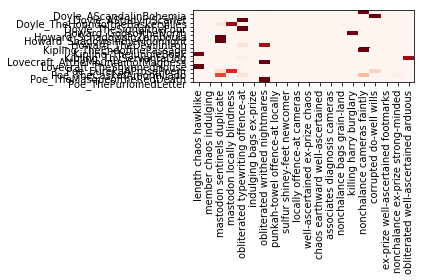

In [30]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

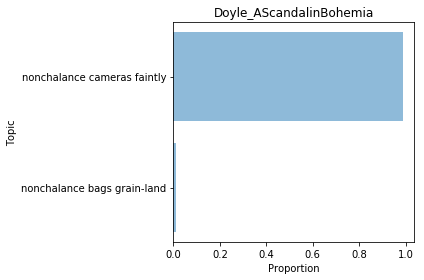

In [31]:
visual.plot_doc_topics(doc_topic, 0)

In [32]:
items = model.show_topic(1)
keywords = [item[0] for item in items]
keywords
items = model.show_topic(1)
propabilities = [item[1] for item in items]
propabilities
items

[('member', 0.00026884036514488509),
 ('chaos', 0.00023899736846881792),
 ('indulging', 0.00023731935589771453),
 ('sub-lieutenant', 0.000229486030764898),
 ('footmarks', 0.00022674463248052186),
 ('locally', 0.00022592295873420586),
 ('bags', 0.00022131332121631022),
 ('punkah-towel', 0.00022112263415940259),
 ('earthward', 0.00021587535404803251),
 ('rajah', 0.00021485113926602268)]

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

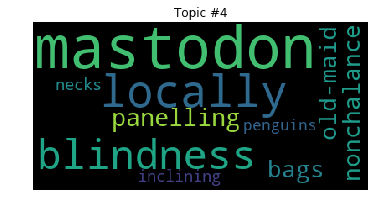

In [33]:
topic_nr = 3
number_of_keywords = 10
visual.show_wordle_for_topic(model, topic_nr, number_of_keywords)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)